# Embeddings, Vector Databases, and Search

Converting text into embedding vectors is the first step to any text processing pipeline. As the amount of text gets larger, there is often a need to save these embedding vectors into a dedicated vector index or library, so that developers won't have to recompute the embeddings and the retrieval process is faster. We can then search for documents based on our intended query and pass these relevant documents into a language model (LM) as additional context. We also refer to this context as supplying the LM with "state" or "memory". The LM then generates a response based on the additional context it receives! 

In this notebook, we will implement the full workflow of text vectorization, vector search, and question answering workflow. While we use [FAISS](https://faiss.ai/) (vector library) and [ChromaDB](https://docs.trychroma.com/) (vector database), and a Hugging Face model, know that you can easily swap these tools out for your preferred tools or models!

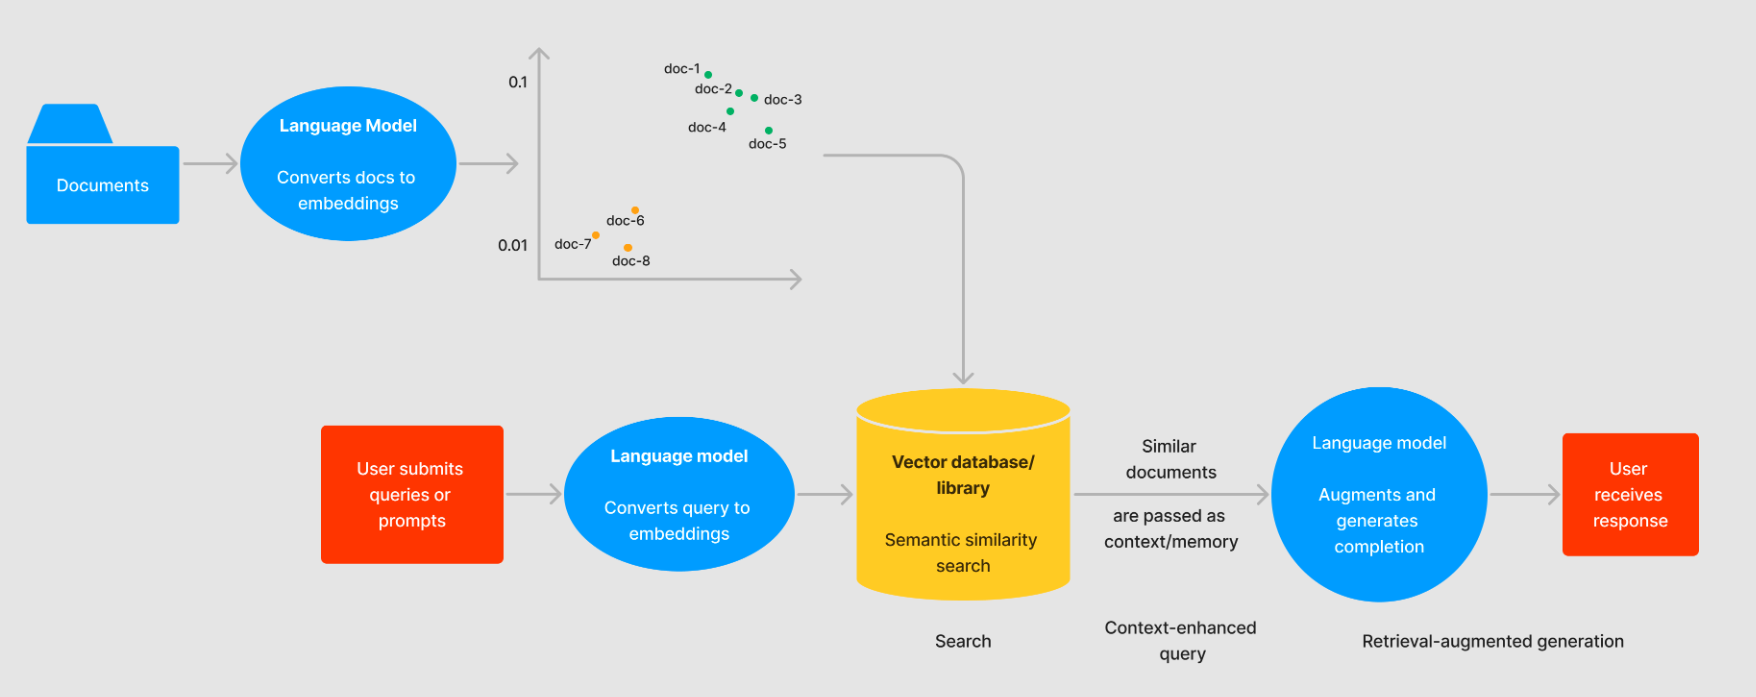

### Learning Objectives
1. Implement the workflow of reading text, converting text to embeddings, saving them to FAISS and ChromaDB 
2. Query for similar documents using FAISS and ChromaDB 
3. Apply a Hugging Face language model for question answering!

## Step 1: Reading data

In this section, we are going to use the data on <a href="https://newscatcherapi.com/" target="_blank">news topics collected by the NewsCatcher team</a>, who collect and index news articles and release them to the open-source community. The dataset can be downloaded from <a href="https://www.kaggle.com/kotartemiy/topic-labeled-news-dataset" target="_blank">Kaggle</a>.

In [1]:
import pandas as pd

pdf = pd.read_csv("../working/cache/labelled_newscatcher_dataset.csv", sep=";")
pdf["id"] = pdf.index
display(pdf)

,topic,link,domain,published_date,title,lang,id
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en,0
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en,1
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,en,2
3,SCIENCE,https://www.ndtv.com/world-news/glaciers-could...,ndtv.com,2020-08-03 22:18:26,Glaciers Could Have Sculpted Mars Valleys: Study,en,3
4,SCIENCE,https://www.thesun.ie/tech/5742187/perseid-met...,thesun.ie,2020-08-12 19:54:36,Perseid meteor shower 2020: What time and how ...,en,4
...,...,...,...,...,...,...,...
108769,NATION,https://www.vanguardngr.com/2020/08/pdp-govern...,vanguardngr.com,2020-08-08 02:40:00,PDP governors’ forum urges security agencies t...,en,108769
108770,BUSINESS,https://www.patentlyapple.com/patently-apple/2...,patentlyapple.com,2020-08-08 01:27:12,"In Q2-20, Apple Dominated the Premium Smartpho...",en,108770
108771,HEALTH,https://www.belfastlive.co.uk/news/health/coro...,belfastlive.co.uk,2020-08-12 17:01:00,Coronavirus Northern Ireland: Full breakdown s...,en,108771
108772,ENTERTAINMENT,https://www.thenews.com.pk/latest/696364-paul-...,thenews.com.pk,2020-08-05 04:59:00,Paul McCartney details post-Beatles distress a...,en,108772


## Vector Library: FAISS

Vector libraries are often sufficient for small, static data. Since it's not a full-fledged database solution, it doesn't have the CRUD (Create, Read, Update, Delete) support. Once the index has been built, if there are more vectors that need to be added/removed/edited, the index has to be rebuilt from scratch. 

That said, vector libraries are easy, lightweight, and fast to use. Examples of vector libraries are [FAISS](https://faiss.ai/), [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [ANNOY](https://github.com/spotify/annoy), and [HNSM](https://arxiv.org/abs/1603.09320).

FAISS has several ways for similarity search: L2 (Euclidean distance), cosine similarity. You can read more about their implementation on their [GitHub](https://github.com/facebookresearch/faiss/wiki/Getting-started#searching) page or [blog post](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/). They also published their own [best practice guide here](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index).

If you'd like to read up more on the comparisons between vector libraries and databases, [here is a good blog post](https://weaviate.io/blog/vector-library-vs-vector-database#feature-comparison---library-versus-database).

In [2]:
from sentence_transformers import InputExample

pdf_subset = pdf.head(1000)

def example_create_fn(doc1: pd.Series) -> InputExample:
    """
    Helper function that outputs a sentence_transformer guid, label, and text
    """
    return InputExample(texts=[doc1])

faiss_train_examples = pdf_subset.apply(
    lambda x: example_create_fn(x["title"]), axis=1
).tolist()

/home/dev-vm/anaconda3/envs/hoangph3/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Step 2: Vectorize text into embedding vectors
We will be using `Sentence-Transformers` [library](https://www.sbert.net/) to load a language model to vectorize our text into embeddings. The library hosts some of the most popular transformers on [Hugging Face Model Hub](https://huggingface.co/sentence-transformers).
Here, we are using the `model = SentenceTransformer("all-MiniLM-L6-v2")` to generate embeddings.

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(
    "all-MiniLM-L6-v2", 
    cache_folder="../working/cache/",
    device="cuda:0"
)  # Use a pre-cached model
faiss_title_embedding = model.encode(pdf_subset.title.values.tolist())
len(faiss_title_embedding), len(faiss_title_embedding[0])

/home/dev-vm/anaconda3/envs/hoangph3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(1000, 384)

### Step 3: Saving embedding vectors to FAISS index
Below, we create the FAISS index object based on our embedding vectors, normalize vectors, and add these vectors to the FAISS index.

In [4]:
import numpy as np
import faiss

pdf_to_index = pdf_subset.set_index(["id"], drop=False)
id_index = np.array(pdf_to_index.id.values).flatten().astype("int")

content_encoded_normalized = faiss_title_embedding.copy()
faiss.normalize_L2(content_encoded_normalized)

# Index1DMap translates search results to IDs: https://faiss.ai/cpp_api/file/IndexIDMap_8h.html#_CPPv4I0EN5faiss18IndexIDMapTemplateE
# The IndexFlatIP below builds index
index_content = faiss.IndexIDMap(faiss.IndexFlatIP(len(faiss_title_embedding[0])))
index_content.add_with_ids(content_encoded_normalized, id_index)

## Step 4: Search for relevant documents

We define a search function below to first vectorize our query text, and then search for the vectors with the closest distance.

In [5]:
def search_content(query, pdf_to_index, k=3):
    query_vector = model.encode([query])
    faiss.normalize_L2(query_vector)

    # We set k to limit the number of vectors we want to return
    top_k = index_content.search(query_vector, k)
    ids = top_k[1][0].tolist()
    similarities = top_k[0][0].tolist()
    results = pdf_to_index.loc[ids]
    results["similarities"] = similarities
    return results

Tada! Now you can query for similar content! Notice that you did not have to configure any database networks beforehand nor pass in any credentials. FAISS works locally with your code.

In [6]:
display(search_content("animal", pdf_to_index))

,topic,link,domain,published_date,title,lang,id,similarities
id,,,,,,,,
176,TECHNOLOGY,https://www.pushsquare.com/news/2020/08/random...,pushsquare.com,2020-08-03 16:30:00,Random: You Can Pick Up and Pet Cats in Assass...,en,176,0.391902
975,HEALTH,https://www.news-medical.net/news/20200813/Res...,news-medical.net,2020-08-13 05:18:00,Researchers explore social behavior of animals...,en,975,0.376784
99,TECHNOLOGY,https://www.gematsu.com/2020/08/ghostwire-toky...,gematsu.com,2020-08-07 16:43:13,Ghostwire: Tokyo confirms dog petting,en,99,0.344058


Up until now, we haven't done the last step of conducting Q/A with a language model yet. We are going to demonstrate this with Chroma, a vector database.

## Vector Database: Chroma

Chroma is an open-source embedding database. The company just raised its [seed funding in April 2023](https://www.trychroma.com/blog/seed) and is quickly becoming popular to support LLM-based applications.

In [7]:
# Build: Custom Embeddings
import importlib
from typing import Optional

import numpy as np
import numpy.typing as npt
from chromadb.api.types import Documents, EmbeddingFunction, Embeddings


class TransformerEmbeddingFunction(EmbeddingFunction):
    def __init__(
            self,
            model_name: str = "all-MiniLM-L6-v2",
            cache_dir: Optional[str] = None,
    ):
        try:
            self._model = SentenceTransformer(model_name, cache_folder="../working/cache/", device="cuda:0" )
        except Exception as e:
            raise ValueError(str(e))

    @staticmethod
    def _normalize(vector: npt.NDArray) -> npt.NDArray:
        """Normalizes a vector to unit length using L2 norm."""
        norm = np.linalg.norm(vector)
        if norm == 0:
            return vector
        return vector / norm

    def __call__(self, input: Documents) -> Embeddings:
        embeddings = self._model.encode(input)
        return [e.tolist() for e in self._normalize(embeddings)]

In [8]:
import chromadb
from chromadb.config import Settings

chroma_client = chromadb.PersistentClient(path="../working/cache/") # this is an optional argument. If you don't supply this, the data will be ephemeral)

### Chroma Concept: Collection

Chroma `collection` is akin to an index that stores one set of your documents. 

According to the [docs](https://docs.trychroma.com/getting-started): 
> Collections are where you will store your embeddings, documents, and additional metadata

The nice thing about ChromaDB is that if you don't supply a model to vectorize text into embeddings, it will automatically load a default embedding function, i.e. `SentenceTransformerEmbeddingFunction`. It can handle tokenization, embedding, and indexing automatically for you. If you would like to change the embedding model, read [here on how to do that](https://docs.trychroma.com/embeddings). TLDR: you can add an optional `model_name` argument. 

You can read [the documentation here](https://docs.trychroma.com/usage-guide#using-collections) on rules for collection names.

In [12]:
collection_name = "my_news"

# If you have created the collection before, you need delete the collection first
if len(chroma_client.list_collections()) > 0 and collection_name in [
    chroma_client.list_collections()[0].name
]:
    chroma_client.delete_collection(name=collection_name)
else:
    print(f"Creating collection: '{collection_name}'")
    collection = chroma_client.create_collection(name=collection_name, embedding_function=TransformerEmbeddingFunction())

Creating collection: 'my_news'


/home/dev-vm/anaconda3/envs/hoangph3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
chroma_client.list_collections()

[Collection(name=my_news)]

### Step 1: Add data to collection

Since we are re-using the same data, we can skip the step of reading data. As mentioned in the text above, Chroma can take care of text vectorization for us, so we can directly add text to the collection and Chroma will convert the text into embeddings behind the scene.

In [14]:
display(pdf_subset)

,topic,link,domain,published_date,title,lang,id
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en,0
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en,1
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,en,2
3,SCIENCE,https://www.ndtv.com/world-news/glaciers-could...,ndtv.com,2020-08-03 22:18:26,Glaciers Could Have Sculpted Mars Valleys: Study,en,3
4,SCIENCE,https://www.thesun.ie/tech/5742187/perseid-met...,thesun.ie,2020-08-12 19:54:36,Perseid meteor shower 2020: What time and how ...,en,4
...,...,...,...,...,...,...,...
995,TECHNOLOGY,https://www.androidcentral.com/mate-40-will-be...,androidcentral.com,2020-08-07 17:12:33,The Mate 40 will be the last Huawei phone with...,en,995
996,SCIENCE,https://www.cnn.com/2020/08/17/africa/stone-ag...,cnn.com,2020-08-17 17:10:00,"Early humans knew how to make comfy, pest-free...",en,996
997,HEALTH,https://www.tenterfieldstar.com.au/story/68776...,tenterfieldstar.com.au,2020-08-13 03:26:06,Regional Vic set for virus testing blitz,en,997
998,HEALTH,https://news.sky.com/story/coronavirus-trials-...,news.sky.com,2020-08-13 13:22:58,Coronavirus: Trials of second contact-tracing ...,en,998


Each document must have a unique `id` associated with it and it is up to you to check that there are no duplicate ids. 

Adding data to collection will take some time to run, especially when there is a lot of data. In the cell below, we intentionally write only a subset of data to the collection to speed things up.

In [15]:
collection.add(
    documents=pdf_subset["title"][:100].tolist(),
    metadatas=[{"topic": topic} for topic in pdf_subset["topic"][:100].tolist()],
    ids=[f"id{x}" for x in range(100)],
)

### Step 2: Query for 10 relevant documents on "space"

We will return 10 most relevant documents. You can think of `10` as 10 nearest neighbors. You can also change the number of results returned as well.

In [16]:
import json

results = collection.query(query_texts=["space"], n_results=10)

print(json.dumps(results, indent=4))

{
    "ids": [
        [
            "id72",
            "id7",
            "id30",
            "id26",
            "id23",
            "id76",
            "id69",
            "id40",
            "id47",
            "id75"
        ]
    ],
    "distances": [
        [
            0.9325035810470581,
            0.9408977031707764,
            0.9491039514541626,
            0.9506462812423706,
            0.9539130926132202,
            0.9589879512786865,
            0.9672824740409851,
            0.9673813581466675,
            0.9683530926704407,
            0.9686463475227356
        ]
    ],
    "metadatas": [
        [
            {
                "topic": "TECHNOLOGY"
            },
            {
                "topic": "SCIENCE"
            },
            {
                "topic": "SCIENCE"
            },
            {
                "topic": "SCIENCE"
            },
            {
                "topic": "SCIENCE"
            },
            {
                "topic": "SCI

### Bonus: Add filter statement

In addition to conducting relevancy search, we can also add filter statements. Refer to the [documentation](https://docs.trychroma.com/usage-guide#using-where-filters) for more information.

In [18]:
collection.query(query_texts=["space"], where={"topic": "SCIENCE"}, n_results=10)

{'ids': [['id7',
   'id30',
   'id26',
   'id23',
   'id76',
   'id69',
   'id40',
   'id47',
   'id75',
   'id52']],
 'distances': [[0.9408977031707764,
   0.9491039514541626,
   0.9506462812423706,
   0.9539130926132202,
   0.9589879512786865,
   0.9672824740409851,
   0.9673813581466675,
   0.9683530926704407,
   0.9686463475227356,
   0.9698429703712463]],
 'metadatas': [[{'topic': 'SCIENCE'},
   {'topic': 'SCIENCE'},
   {'topic': 'SCIENCE'},
   {'topic': 'SCIENCE'},
   {'topic': 'SCIENCE'},
   {'topic': 'SCIENCE'},
   {'topic': 'SCIENCE'},
   {'topic': 'SCIENCE'},
   {'topic': 'SCIENCE'},
   {'topic': 'SCIENCE'}]],
 'embeddings': None,
 'documents': [['Orbital space tourism set for rebirth in 2021',
   'NASA drops "insensitive" nicknames for cosmic objects',
   '‘It came alive:’ NASA astronauts describe experiencing splashdown in SpaceX Dragon',
   'Hubble Uses Moon As “Mirror” to Study Earth’s Atmosphere – Proxy in Search of Potentially Habitable Planets Around Other Stars',
   "

### Bonus: Update data in a collection

Unlike a vector library, vector databases support changes to the data so we can update or delete data. 

Indeed, we can update or delete data in a Chroma collection.

In [19]:
collection.get(
    ids=["id0"],
)

{'ids': ['id0'],
 'embeddings': None,
 'metadatas': [{'topic': 'SCIENCE'}],
 'documents': ["A closer look at water-splitting's solar fuel potential"]}

In [20]:
collection.delete(ids=["id0"])

Delete of nonexisting embedding ID: id0


The record with `ids=0` is no longer present.

In [22]:
collection.get(
    ids=["id0"],
)

{'ids': [], 'embeddings': None, 'metadatas': [], 'documents': []}

We can also update a specific data point.

In [23]:
collection.get(
    ids=["id2"],
)

{'ids': ['id2'],
 'embeddings': None,
 'metadatas': [{'topic': 'SCIENCE'}],
 'documents': ['Artificial intelligence warning: AI will know us better than we know ourselves']}

In [24]:
collection.update(
    ids=["id2"],
    metadatas=[{"topic": "TECHNOLOGY"}],
)

In [25]:
collection.get(
    ids=["id2"],
)

{'ids': ['id2'],
 'embeddings': None,
 'metadatas': [{'topic': 'TECHNOLOGY'}],
 'documents': ['Artificial intelligence warning: AI will know us better than we know ourselves']}

## Prompt engineering for question answering 

Now that we have identified documents about space from the news dataset, we can pass these documents as additional context for a language model to generate a response based on them! 

We first need to pick a `text-generation` model. Below, we use a Hugging Face model. You can also use OpenAI as well, but you will need to get an Open AI token and [pay based on the number of tokens](https://openai.com/pricing).

In [26]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

model_id = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir="../working/cache/")
lm_model = AutoModelForCausalLM.from_pretrained(model_id, cache_dir="../working/cache/")

pipe = pipeline(
    "text-generation",
    model=lm_model,
    tokenizer=tokenizer,
    do_sample=True,
    temperature=0.9,
    max_length=512,
    device='cuda:0',
)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

/home/dev-vm/anaconda3/envs/hoangph3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Here's where prompt engineering, which is developing prompts, comes in. We pass in the context in our `prompt_template` but there are numerous ways to write a prompt. Some prompts may generate better results than the others and it requires some experimentation to figure out how best to talk to the model. Each language model behaves differently to prompts. 

Our prompt template below is inspired from a [2023 paper on program-aided language model](https://arxiv.org/pdf/2211.10435.pdf). The authors have provided their sample prompt template [here](https://github.com/reasoning-machines/pal/blob/main/pal/prompt/date_understanding_prompt.py).

The following links also provide some helpful guidance on prompt engineering: 
- [Prompt engineering with OpenAI](https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-openai-api)
- [GitHub repo that compiles best practices to interact with ChatGPT](https://github.com/f/awesome-chatgpt-prompts)

In [30]:
question = "What's the latest news on space development?"
context = " ".join([f"#{str(i)}" for i in results["documents"][0]])
prompt_template = f"Relevant context: {context}\n\n The user's question: {question}"

In [31]:
context

'#Beck teams up with NASA and AI for \'Hyperspace\' visual album experience #Orbital space tourism set for rebirth in 2021 #NASA drops "insensitive" nicknames for cosmic objects #‘It came alive:’ NASA astronauts describe experiencing splashdown in SpaceX Dragon #Hubble Uses Moon As “Mirror” to Study Earth’s Atmosphere – Proxy in Search of Potentially Habitable Planets Around Other Stars #Australia\'s small yet crucial part in the mission to find life on Mars #NASA Astronauts in SpaceX Capsule Splashdown in Gulf Of Mexico #SpaceX\'s Starship spacecraft saw 150 meters high #NASA’s InSight lander shows what’s beneath Mars’ surface #Alien base on Mercury: ET hunters claim to find huge UFO'

In [32]:
lm_response = pipe(prompt_template)
print(lm_response[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Relevant context: #Beck teams up with NASA and AI for 'Hyperspace' visual album experience #Orbital space tourism set for rebirth in 2021 #NASA drops "insensitive" nicknames for cosmic objects #‘It came alive:’ NASA astronauts describe experiencing splashdown in SpaceX Dragon #Hubble Uses Moon As “Mirror” to Study Earth’s Atmosphere – Proxy in Search of Potentially Habitable Planets Around Other Stars #Australia's small yet crucial part in the mission to find life on Mars #NASA Astronauts in SpaceX Capsule Splashdown in Gulf Of Mexico #SpaceX's Starship spacecraft saw 150 meters high #NASA’s InSight lander shows what’s beneath Mars’ surface #Alien base on Mercury: ET hunters claim to find huge UFO

 The user's question: What's the latest news on space development?

Here's the relevant context:

"We are still investigating the possibilities that might be lurking in the inner depths of Mars and the outer atmosphere. It is possible that Mars is undergoing a 'high-frequency gamma ray' in t

Yay, you have just completed the implementation of your first text vectorization, search, and question answering workflow (that requires prompt engineering)!

In the lab, you will apply your newly gained knowledge to a different dataset. You can also check out the optional modules on Pinecone and Weaviate to learn how to set up vector databases that offer enterprise offerings.

&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>